# This notebook aims to give a exploratory look at the project data

In [4]:
!pip install rioxarray

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 21.4 MB/s  0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 6.3/6.3 MB 45.7 MB/s  0:00:00
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ----------------- ---------------------- 13.1/30.1 MB 65.2 MB/s eta 0:00:01
   ------------------------------------- -- 28.3/30.1 MB 68.9 MB/s eta 0:00:01
   ---------------------------------------- 30.1/30.1 MB 58.7 MB/s  0:00:00

   ---------------------------------------- 0/8 [pyproj]
   ---------- ----------------------------- 2/8 [attrs]
  Attempting uninstall: xarray
   ---------- ----------------------------- 2/8 [attrs]
    Found existing installation: xarray 2026.1.0
   ---------- ----------------------------- 2/8 [attrs]
    Uninstalling xarray-2026.1.0:
   ---------- ----------------------------- 2/8 [attrs]
      Successf

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rxr

In [6]:
ESM5_data = xr.open_dataset("../data/CanESM5_historical_tas.nc", engine="netcdf4")

## Variables and dimensions
- **Dimensions**:
  - `member` (25): ensemble members.
  - `time` (1980): monthly steps from 1850–2014 (noleap calendar).
  - `lat` (64), `lon` (128): spatial grid.
  - `bnds` (2): bounds for time/lat/lon intervals.
- **Coordinates**: `member`, `time`, `lat`, `lon`, `height`.
- **Data variables**:
  - `tas`: near-surface air temperature in Kelvin, shape `(member, time, lat, lon)`.
  - `time_bnds`, `lat_bnds`, `lon_bnds`: bounds for each coordinate.

<xarray.Dataset> Size: 2GB
Dimensions:    (member: 25, time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * member     (member) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member, time, bnds) object 792kB ...
    lat_bnds   (member, lat, bnds) float64 26kB ...
    lon_bnds   (member, lon, bnds) float64 51kB ...
    tas        (member, time, lat, lon) float32 2GB ...
Attributes: (12/53)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his01
    Conventions:                

C:\Users\usuario\AppData\Local\Temp\ipykernel_39284\696006946.py:21: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
C:\Users\usuario\AppData\Local\Temp\ipykernel_39284\696006946.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())


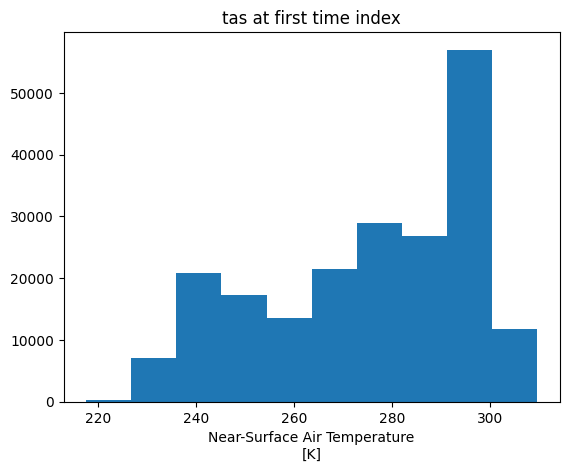

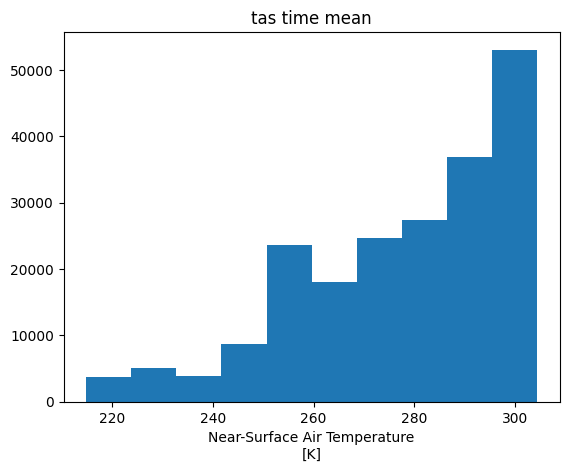

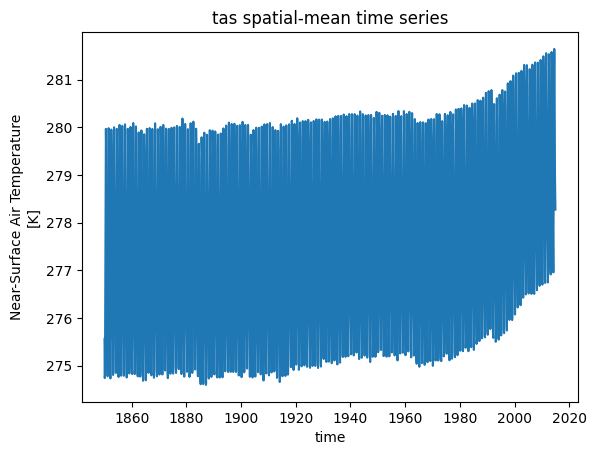

In [12]:
# Dataset overview
print(ESM5_data)
print("\nDimensions:", ESM5_data.dims)
print("Coordinates:", list(ESM5_data.coords))
print("Data variables:", list(ESM5_data.data_vars))

# Prefer the primary climate variable if present
if "tas" in ESM5_data.data_vars:
    var_name = "tas"
else:
    # Fall back to the first non-bounds variable
    non_bnds = [v for v in ESM5_data.data_vars if not v.endswith("_bnds")]
    var_name = non_bnds[0] if non_bnds else list(ESM5_data.data_vars)[0]
da = ESM5_data[var_name]
print("\nSelected variable:", var_name)
print(da)

# Convert time to pandas datetime if needed (avoid nc-time-axis requirement)
if "time" in da.coords:
    try:
        da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
    except Exception:
        pass

# Plot a snapshot (first time index if time exists)
if "time" in da.dims:
    da.isel(time=0).plot()
    plt.title(f"{var_name} at first time index")
else:
    da.plot()
    plt.title(f"{var_name} snapshot")
plt.show()

# Plot time-mean spatial field (if time exists)
if "time" in da.dims:
    da.mean("time").plot()
    plt.title(f"{var_name} time mean")
    plt.show()

# Plot a spatial mean time series (if time exists)
if "time" in da.dims:
    spatial_dims = [d for d in da.dims if d != "time"]
    if spatial_dims:
        da.mean(spatial_dims).plot()
        plt.title(f"{var_name} spatial-mean time series")
        plt.show()

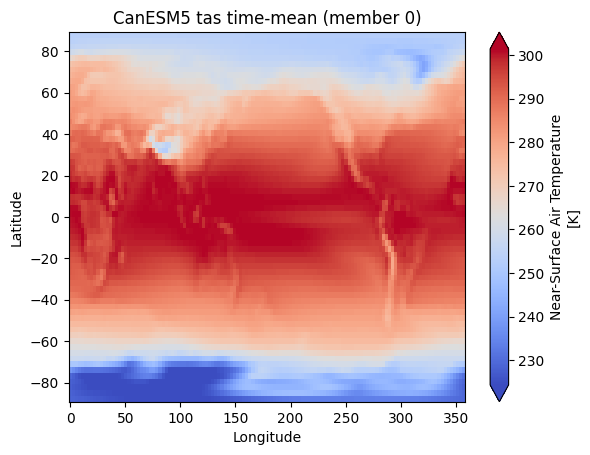

In [13]:
# Map of tas (time-mean, member 0)
map_da = ESM5_data["tas"]
if "time" in map_da.dims:
    map_da = map_da.mean("time")
if "member" in map_da.dims:
    map_da = map_da.isel(member=0)
map_da.plot(x="lon", y="lat", cmap="coolwarm", robust=True)
plt.title("CanESM5 tas time-mean (member 0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()